# DSA4212 Assignment 1: Starter Kit

In [ ]:
import numpy as np
## Progress bar
from tqdm.auto import tqdm
import pylab as plt
import copy
import time
import random

random.seed(2)

In [ ]:
if 'google.colab' in str(get_ipython()):
  print("All ok -- code is running on a Google Colab")
else:
    print("==="*15, " WARNING ","==="*15)
    print("For DSA4212 assignment 1, code needs to be run on a Google Colab with a single GPU")
    print("==="*15, " WARNING ","==="*15)



All ok -- code is running on a Google Colab


In [ ]:
!nvidia-smi -L
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-5b556c7f-caef-03fe-4d56-506082c4aaef)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
12G


# Connect to Google Drive & Load data

In [ ]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd

'/content'

In [ ]:
# goto to data folder -- you may need to change this location
%cd drive/MyDrive/DSA4212

/content/drive/MyDrive/DSA4212


In [ ]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few secs
data_train_all = np.load("assignment_1_train.npz")
data_test = np.load("assignment_1_test.npz")

X_train_all = data_train_all["img"].astype(np.float32) / 255.   # set pixel intensities to [0,1]
X_test = data_test["img"].astype(np.float32) / 255.
Y_train_all = data_train_all["label"].astype(int)
Y_test = data_test["label"].astype(int)

_,H,W,C = X_train_all.shape
print(f"Img Shape: {H}x{W}x{C}")

Img Shape: 128x128x3


In [ ]:
# shuffle the train set
indices_shuffled = np.arange(len(X_train_all))
np.random.shuffle(indices_shuffled)
X_train_all = X_train_all[indices_shuffled]
Y_train_all = Y_train_all[indices_shuffled]

# shuffle the validation set
indices_shuffled = np.arange(len(X_test))
np.random.shuffle(indices_shuffled)
X_test = X_test[indices_shuffled]
Y_test = Y_test[indices_shuffled]

In [ ]:
sz_train = X_train_all.size * X_train_all.itemsize / 2.**30
sz_val = X_test.size * X_test.itemsize / 2.**30

print(f"Training Set Size: {sz_train:2.2f} Go")
print(f"Validaton Set Size: {sz_val:2.2f} Go")

Training Set Size: 1.70 Go
Validaton Set Size: 0.71 Go


# Split Train / Validation / Test

The test set can only be used for the final evaluation of the model: one cannot use the test set when tuning the models. Consequently, we are going to split `X_train_all` into a train-set and a validation-set.

In [ ]:
len_train_all = len(X_train_all)
len_train = int(0.8 * len_train_all)
len_val = len_train_all - len_train
len_tets = len(X_test)

X_train = X_train_all[:len_train]
Y_train = Y_train_all[:len_train]

X_val = X_train_all[len_train:]
Y_val = Y_train_all[len_train:]


# Sanity checks
Let us make sure that the data is all ok

Text(0.5, 1.0, 'Pixel Intensity')

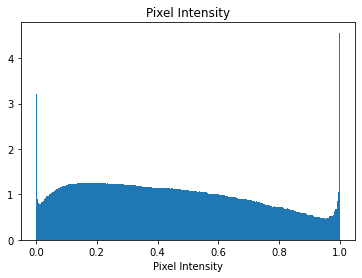

In [ ]:
# histogram of pixel intensities
_ = plt.hist(X_train.ravel(), bins=256, density=True)
plt.xlabel("Pixel Intensity")
plt.title("Pixel Intensity")

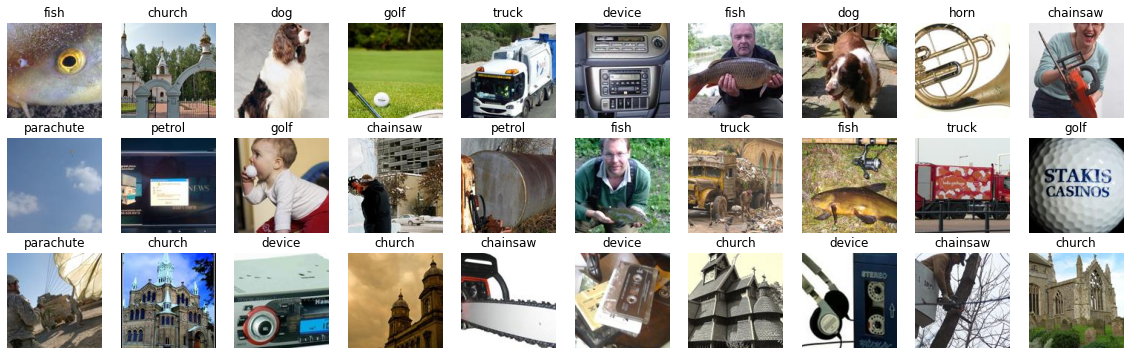

In [ ]:
# train set:: sanity check
# plt a few random images in the trainset as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_train))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_train[index,:,:,:])
    plt.title(class_names[Y_train[index]])

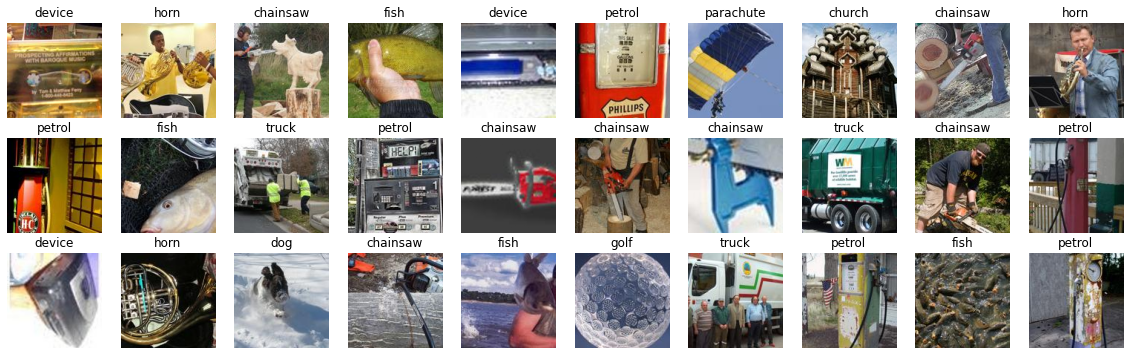

In [ ]:
# validation set:: sanity check
# plt a few images as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_val))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_val[index,:,:,:])
    plt.title(class_names[Y_val[index]])

In [ ]:
# load FLAX and install it if not installed already
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

import flax
from flax import linen as nn

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [ ]:
import jax
import jax.numpy as jnp
from typing import Any, Sequence

try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

In [ ]:
class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)

class SimpleCNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = LayerNorm()(x)
            x = nn.elu( nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 2, padding='SAME', name=f'layers_{i}_1')(x) )
            #x = nn.avg_pool(x,(2, 2), strides=(2, 2))
            
        # pooling -- average across the dimension (1,2)
        x =  x.mean(axis=(1,2))
    
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        #convert to proba
        probas = nn.softmax(x)
        return probas

In [ ]:
# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
net = SimpleCNN(n_filters=[16,32,64], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key
key, key_ = jax.random.split(key)
batch_size = 32
batch_of_images = X_train[:batch_size,:,:,:]
params_init = net.init(key_, batch_of_images)

# count the number of parameters
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params_init))
print(f"Number of Neural Parameters: {param_count//1000}k")

Number of Neural Parameters: 24k


In [ ]:
@jax.jit
def loss(params, x, y):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = net.apply(params, x)
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * jnp.log(pred), axis=1)
  return jnp.mean(CEs)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [ ]:
@jax.jit
def prediction_class(params, x):
  """ make a prediction """
  pred = net.apply(params, x)
  pred_class = jnp.argmax(pred, axis=1)
  return pred_class

@jax.jit
def accuracy(params, x, y):
  """
  compute the accuracy on a batch of images

  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred_class = prediction_class(params, x)
  return jnp.mean(pred_class == y)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [ ]:
# let us randomize the weights again to start from scratch
params = copy.deepcopy(params_init)
import tensorflow as tf
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
#define the ADAM optimizer with learning rate that decays in an exponential function
optimizer = optax.adamw(learning_rate=0.01692, b1=0.9, b2=0.999, eps=1e-08, eps_root=0.0, mu_dtype=None, weight_decay=0.00015, mask=None)

#generate the initial state of the optimizer
opt_state = optimizer.init(params)

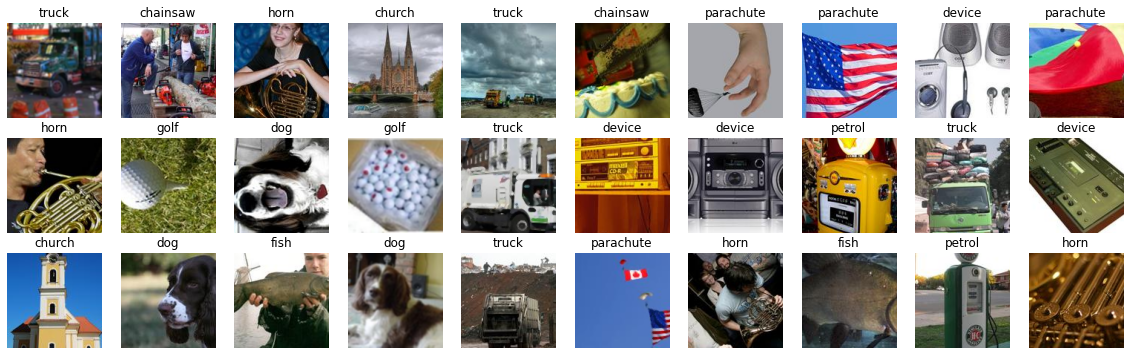

In [ ]:
import albumentations as A
import numpy as np
import cv2

#pipeline to augment images
transforms = A.Compose([
            A.OneOf([A.MedianBlur(blur_limit=5, p=0.25),
            A.Blur(blur_limit=3, p=0.25),
            A.RandomRotate90(),
            A.Transpose()
            ], p=0.25),
        
    ])
'''
transforms = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])
'''
augmented_imgs = []
for i in X_train:
  transformed = transforms(image=i)
  augmented_image = transformed['image']
  augmented_imgs.append(augmented_image)
augmented_imgs = np.array(augmented_imgs)

#check if images have been transformed
plt.figure(figsize=(10*2,3*2))
for k in range(3*10):
  index = np.random.randint(low=0,high=len(augmented_imgs))
  plt.subplot(3,10,k+1)
  plt.axis('off')
  plt.imshow(augmented_imgs[index,:,:,:])
  plt.title(class_names[Y_train[index]])

#New dataset for training images
X_train_aug = jnp.concatenate((X_train,augmented_imgs))
Y_train_aug = jnp.concatenate((Y_train,Y_train))


In [ ]:
# shuffle the train set
indices_shuffled = np.arange(len(X_train_aug))
np.random.shuffle(indices_shuffled)
X_train_aug = X_train_aug[indices_shuffled]
Y_train_aug = Y_train_aug[indices_shuffled]


In [ ]:
# put data to GPU
X_train_aug = jax.device_put(X_train_aug)
X_val = jax.device_put(X_val)


In [ ]:
niter = 1000
batch_size = 512

# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train_aug)
  X_batch = X_train_aug[indices]
  Y_batch = Y_train_aug[indices]

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the validation accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train_aug[:N], Y_train_aug[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train_aug)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, X_val[:N], Y_val[:N])
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append( loss_train.item() )

  0%|          | 0/1000 [00:00<?, ?it/s]

Time:7.0sec 	 Epoch:0.0 	 Loss [2.31 / 2.31] 	 Accuracy Train/Valid: [9.38% / 10.35%]
Time:17.0sec 	 Epoch:1.8 	 Loss [1.48 / 1.65] 	 Accuracy Train/Valid: [48.44% / 43.75%]
Time:19.8sec 	 Epoch:3.5 	 Loss [1.28 / 1.41] 	 Accuracy Train/Valid: [58.01% / 54.30%]
Time:23.1sec 	 Epoch:5.2 	 Loss [1.14 / 1.28] 	 Accuracy Train/Valid: [62.30% / 59.96%]
Time:26.1sec 	 Epoch:6.9 	 Loss [1.06 / 1.18] 	 Accuracy Train/Valid: [65.23% / 60.94%]
Time:29.0sec 	 Epoch:8.6 	 Loss [0.95 / 1.14] 	 Accuracy Train/Valid: [68.55% / 64.06%]
Time:31.9sec 	 Epoch:10.4 	 Loss [0.89 / 1.12] 	 Accuracy Train/Valid: [69.92% / 63.28%]
Time:34.9sec 	 Epoch:12.1 	 Loss [0.88 / 1.03] 	 Accuracy Train/Valid: [74.41% / 68.36%]
Time:38.2sec 	 Epoch:13.8 	 Loss [0.76 / 1.05] 	 Accuracy Train/Valid: [72.85% / 66.02%]
Time:41.1sec 	 Epoch:15.5 	 Loss [0.75 / 0.99] 	 Accuracy Train/Valid: [77.54% / 67.97%]
Time:44.0sec 	 Epoch:17.2 	 Loss [0.64 / 0.98] 	 Accuracy Train/Valid: [80.27% / 68.55%]
Time:46.9sec 	 Epoch:19.0 	 L

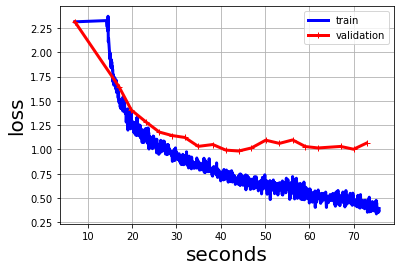

In [ ]:
plt.plot(loss_train_history_time, loss_train_history, "b-", lw = 3, label="train")
plt.plot(loss_val_history_time, loss_val_history, "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()


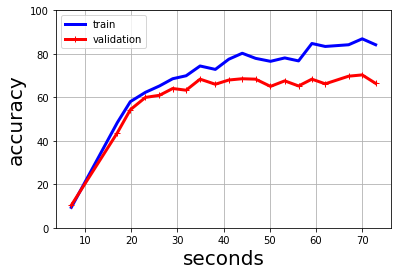

In [ ]:
accuracies_history = np.array(accuracies_history)
plt.plot(accuracies_history_time, accuracies_history[:,0], "b-", lw = 3, label="train")
plt.plot(accuracies_history_time, accuracies_history[:,1], "r-+", lw = 3, label="validation")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.ylim(0,100)
plt.grid(True)
plt.legend()

# Test Accuracy
Note we have at no point used the test-set previously.

In [ ]:
# final test accuracy
pred_test = []
n_forward_pass = len(X_test) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_test.append( prediction_class(params, X_test[k*batch_size:(k+1)*batch_size]) )
# final forward pass
pred_test.append( prediction_class(params, X_test[n_forward_pass*batch_size:]) )

pred_test = np.concatenate(pred_test)
acc_test = 100*jnp.mean(pred_test == Y_test)
print( f"Final Test Accuracy: {acc_test:2.1f}%")

  0%|          | 0/7 [00:00<?, ?it/s]

Final Test Accuracy: 70.0%
